In [49]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [50]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [51]:
emb_df = pd.read_csv('../data/embedding/Doc2Vec_embedding_output.csv',index_col=0)

In [52]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.146739,-2.738958,3.672001,4.319488,2.060131,1.106603,2.756807,-1.807586,3.119252,-0.814754,...,2.498754,-1.766720,0.291909,-0.236563,0.366089,-2.615653,2.517367,-2.121267,4.024024,1.430665
1,-3.081997,-4.560731,-0.439482,2.801814,-2.063705,0.320462,2.700044,-1.313459,2.488874,-1.288608,...,3.506879,1.340675,0.644034,0.583566,-1.396967,-2.599615,0.540591,-0.846946,0.476570,1.209218
2,-0.923654,-0.931160,0.270649,0.993372,1.246490,1.068892,0.833382,-0.559276,1.961053,-4.149379,...,5.081479,1.130174,-2.890191,-2.820214,1.395403,-3.846228,-1.152302,-2.224700,1.176310,-0.315757
3,-0.047425,-3.906727,0.635823,0.752494,1.742398,0.973911,0.725889,-0.415176,3.048928,-2.944524,...,3.968297,0.803104,-1.049701,-2.646564,0.847253,-2.600662,-0.752832,0.028893,-0.424166,-1.445955
4,-6.648052,-0.395714,2.429264,2.590817,-0.684888,-1.006098,0.028183,2.124310,1.596855,-2.533973,...,-1.403458,-1.843892,-0.527678,-3.595732,-2.341160,-1.960664,-0.313663,-3.191498,0.681570,-2.437148


In [53]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [54]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [55]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [56]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 'cave_rescue'

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 'duckboat'

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 'helsinki'

In [57]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,cave_rescue
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,cave_rescue
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,cave_rescue
3,chron.com/news/crime/article/young-nubians-rev...,cave_rescue
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,cave_rescue
...,...,...
1920,beforeitsnews.com/opinion-conservative/2018/07...,helsinki
1921,washingtonpost.com/news/powerpost/paloma/the-h...,helsinki
1922,feeds.nydailynews.com/~r/nydnrss/news/national...,helsinki
1923,news.google.com/stories/caaqoqgkijndqkltsurvsm...,helsinki


In [58]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [59]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [60]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((624, 10), (176045, 10))

Sample and include all the labeled article

In [61]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [68]:
sample_emb_df = emb_df.loc[sample_df.index]

In [69]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(sample_emb_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [70]:
admat = nn.kneighbors_graph( mode='connectivity'); admat

<10624x10624 sparse matrix of type '<class 'numpy.float64'>'
	with 106240 stored elements in Compressed Sparse Row format>

In [71]:
G = nx.from_scipy_sparse_matrix(admat)

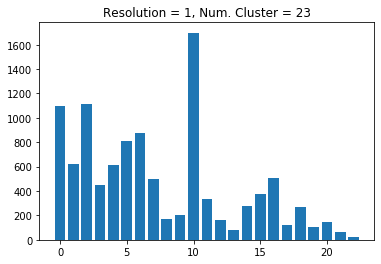

In [72]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [73]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(10, 1698, 332.0)

In [74]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [77]:
pc = clusters# prune_cluster(cluster, 5)

In [94]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

23

In [95]:
len(article_cluster[0].title.tolist())

1093

In [96]:
pc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [98]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
FBI Chief Threatens To Quit If Trump Invites Russian Agents To US | Zero Hedge
Vietnam Warns of Floods, Landslides After Tropical Storm Son Tinh Hits -
Court Holds Government Accountable for 2014 Ferry Sinking for the First
Google News - Eight dead after boat capsized on Missouri lake - Overview
meets Vladimir Putin - Overview
Google News - Danica Patrick hosts ESPY Awards - Overview
Home demolitions may create new problem: lead-tainted dust - news - CenturyLink
Bristol Palin joining MTV reality series 'Teen Mom OG'
Trump 'relentless' against Russia, won't let Kremlin question US officials, Pompeo tells FOX | Fox News
Falls Over 80 Points as White House Escalates Trade Tensions
-------------------------------------------------- text --------------------------------------------------
by Knave Dave - Jul 18, 2018 1:11 pm ### This is EXACTLY what the first stage of a housing collaps

## Top clusters

In [99]:
cluster_sizes = np.array(list(map(len, article_cluster)))

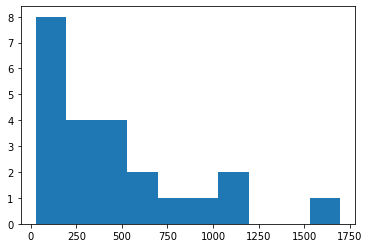

In [100]:
plt.hist(cluster_sizes);

In [101]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1698, 1112, 1093,  875,  811,  622,  611,  509,  498,  449,  379,
        332,  279,  269,  205,  172,  166,  147,  124,  105,   78,   63,
         27])

In [102]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
10852,33,washingtonpost.com/opinions/help-is-at-hand-fo...,7/19/2018 6:44:22 PM -04:00,Help is at hand for Palestinians — if Hamas se...,Help is at hand for Palestinians — if Hamas se...,1,en,58,5325,helsinki
11440,22,nytimes.com/aponline/2018/07/18/science/ap-us-...,7/19/2018 6:02:01 AM -04:00,Study: National Parks Get Fewer Visits When Po...,Study: National Parks Get Fewer Visits When Po...,1,en,61,4051,cave_rescue
17708,34,bbc.co.uk/news/av/uk-wales-44885593/dad-s-deva...,7/19/2018 6:42:48 AM -04:00,Thomas Channon: Dad's devastation at son's Mag...,Media playback is unsupported on your device #...,1,en,50,898,helsinki
31404,16,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,7/20/2018 9:16:42 PM -04:00,duck boat capsized in Missouri - Overview,A duck boat capsized in Missouri ### Top cover...,1,en,41,13905,cave_rescue


In [103]:
print('\n'.join(top_cluster.title.tolist()[:10]))

Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Help is at hand for Palestinians — if Hamas sets them free
Study: National Parks Get Fewer Visits When Pollution Rises -
Thomas Channon: Dad's devastation at son's Magaluf
duck boat capsized in Missouri - Overview
duck boat capsized in Missouri - Overview
meets Vladimir Putin - Overview
Stocks slide after disappointing earnings, Trump dumps on Fed | Seeking Alpha
Facebook reportedly touted Trump campaign as an ‘innovator’ - CNET
Ford recalls 550,000 Escape, Fusion vehicles over rollaway concerns - Roadshow


In [104]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

C:\Users\harinsa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [105]:
articles = pd.concat(article_cluster)

In [106]:
articles.dropna(subset=['label'])

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment
11,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,helsinki,0
61,290,zerohedge.com/news/2018-07-19/skripal-poisonin...,7/19/2018 11:16:00 AM -04:00,"Skripal Poisoning Suspects 'Identified': ""[We'...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,71,3105,helsinki,0
13337,237,hotair.com/headlines/archives/2018/07/house-de...,7/19/2018 2:46:06 PM -04:00,"House Dems bet on ""For the People"" slogan to c...",House Dems bet on “For the People” slogan to c...,1,en,84,962,helsinki,0
17111,34,bbc.co.uk/news/uk-scotland-glasgow-west-44872560,7/19/2018 5:05:25 AM -04:00,Glasgow road re-opens after burst water main c...,Glasgow road re-opens after burst water main c...,1,en,71,1224,cave_rescue,0
17649,34,bbc.co.uk/news/av/world-asia-44875088/thai-cav...,7/19/2018 6:00:43 AM -04:00,Thailand cave rescue: Boy 'shocked' to be foun...,Media playback is unsupported on your device #...,1,en,58,441,cave_rescue,0
...,...,...,...,...,...,...,...,...,...,...,...
162164,94,chicagotribune.com/suburbs/lake-county-news-su...,7/19/2018 8:25:21 PM -04:00,Outcry in Zion over video of dead dog in trash...,Outcry in Zion over video of dead dog in trash...,1,en,103,5051,cave_rescue,20
169692,165,startribune.com/third-game-in-nine-days-a-grin...,7/20/2018 1:35:21 AM -04:00,Third game in nine days a grind for winning bu...,Purchase: Order Reprint ### ### Through his 9...,1,en,77,2927,duckboat,20
73635,6,yahoo.com/news/m/2754ec44-9023-35c4-8609-d452f...,7/19/2018 5:40:06 AM -04:00,'We took turns digging at the cave walls': Tha...,'We took turns digging at the cave walls': Tha...,1,en,69,1116,cave_rescue,21
132101,256,sandiegouniontribune.com/la-na-missouri-boat-2...,7/20/2018 12:24:46 AM -04:00,8 dead as Missouri tour boat with 30 aboard ca...,8 dead as Missouri tour boat with 30 aboard ca...,1,en,82,2239,helsinki,21


In [115]:
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()

In [116]:
HTML(assignments.to_html())